In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.titlesize'] = 18

In [110]:
nopts = pd.read_csv('big/noptsubs.txt', delimiter="|")
nopts['received_at'] = pd.to_datetime(nopts['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
nopts['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') for x in nopts['received_at'].values])

nopts.head()

,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,substring,slot_boundary
0,2023-03-13 17:57:45.774553,f,12410,1786,75578,6903,96678,0x978a35,2023-03-13 17:57:48
1,2023-03-13 17:57:45.698805,f,89843,1617,105741,6568,203771,0xa82f9a,2023-03-13 17:57:48
2,2023-03-13 17:57:45.810121,f,7900,1768,96445,7302,113417,0x84b02b,2023-03-13 17:57:48
3,2023-03-13 17:57:43.602490,f,90470,1353,98227,5276,195328,0xa1dead,2023-03-13 17:57:48
4,2023-03-13 17:57:43.675843,f,87590,1465,101181,5469,195707,0xa85807,2023-03-13 17:57:48


In [50]:
opts = pd.read_csv('big/optsubs.txt', delimiter="|")
opts['received_at'] = pd.to_datetime(opts['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
opts['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') for x in opts['received_at'].values])

opts.head()

,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,substring,slot_boundary
0,2023-03-17 12:12:33.673550,t,12062,1407,11,5999,19481,0xb33333,2023-03-17 12:12:36
1,2023-03-17 12:12:20.659166,t,101735,1449,7,5578,108770,0x83d349,2023-03-17 12:12:24
2,2023-03-17 12:12:20.822450,t,11241,2096,10,6061,19409,0x978a35,2023-03-17 12:12:24
3,2023-03-17 12:12:21.083129,t,135937,1408,10,8629,145986,0x83d349,2023-03-17 12:12:24
4,2023-03-17 12:12:22.254343,t,234029,1672,7,5794,241504,0x83d349,2023-03-17 12:12:24


In [111]:
len(nopts), len(opts)

(1000000, 912063)

In [112]:
np.percentile(opts['total_duration'].values, 99)

1153253.32

In [113]:
bdo = opts[opts['total_duration'] < np.percentile(opts['total_duration'].values, 99)]['total_duration'].values
bdn = nopts[nopts['total_duration'] < np.percentile(nopts['total_duration'].values, 99)]['total_duration'].values

In [114]:
len(bdn), len(bdo)

(990000, 902942)

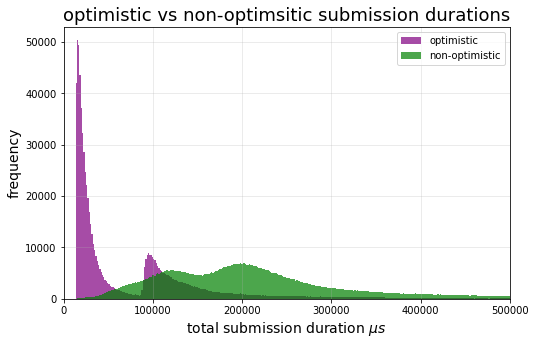

In [115]:
f, ax = plt.subplots(figsize=(8,5))

bins = np.histogram(bdn, bins=1000)[1]
ax.hist(bdo, bins, color='purple', alpha=0.7, density=False, label='optimistic')
ax.hist(bdn, bins, color='g', alpha=0.7, density=False, label='non-optimistic')
ax.set_xlim(0,float(0.5e6))
ax.set_xlabel('total submission duration $\mu s$', size=14)
ax.set_ylabel('frequency', size=14)
ax.set_title('optimistic vs non-optimsitic submission durations', size=18)
plt.legend()
plt.show()

In [58]:
pks = set(opts['substring'])

In [60]:
builders = pd.read_csv('big/builders.txt', delimiter="|")
builders.head()

,substring,is_optimistic,is_high_prio,collateral,builder_id,description
0,0xaec4ec,t,t,1000000000000000000,beaverbuild,beaver
1,0x96a59d,t,t,1000000000000000000,beaverbuild,beaver
2,0xb5d883,t,t,1000000000000000000,beaverbuild,beaver
3,0x8dde59,t,t,1000000000000000000,beaverbuild,beaver
4,0x8c344f,t,t,1000000000000000000,bob,bob


In [64]:
descriptions = builders[['substring', 'builder_id']].copy()
descriptions.head()

,substring,builder_id
0,0xaec4ec,beaverbuild
1,0x96a59d,beaverbuild
2,0xb5d883,beaverbuild
3,0x8dde59,beaverbuild
4,0x8c344f,bob


In [119]:
opts_builders = opts.merge(descriptions, on='substring', how='left')
opts_builders.head()

,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,substring,slot_boundary,builder_id
0,2023-03-17 12:12:33.673550,t,12062,1407,11,5999,19481,0xb33333,2023-03-17 12:12:36,smithbot
1,2023-03-17 12:12:20.659166,t,101735,1449,7,5578,108770,0x83d349,2023-03-17 12:12:24,rsync
2,2023-03-17 12:12:20.822450,t,11241,2096,10,6061,19409,0x978a35,2023-03-17 12:12:24,rsync
3,2023-03-17 12:12:21.083129,t,135937,1408,10,8629,145986,0x83d349,2023-03-17 12:12:24,rsync
4,2023-03-17 12:12:22.254343,t,234029,1672,7,5794,241504,0x83d349,2023-03-17 12:12:24,rsync


In [120]:
buids = set(opts_builders['builder_id'])
buids.remove('BuildAI')
buids

{'Titan',
 'beaverbuild',
 'bob',
 'builder0x69',
 'finest',
 'manta',
 'rsync',
 'smithbot'}

In [121]:
bdo = opts_builders[opts_builders['total_duration'] < np.percentile(opts_builders['total_duration'].values, 99)]

In [122]:
len(bdo[bdo['builder_id']=='builder0x69'])

240433

In [123]:
bins = np.histogram(bdo[bdo['builder_id']=='builder0x69']['total_duration'].values, bins=500)[1]

In [124]:
colors = plt.cm.copper(np.linspace(0, 1, 8))

0 0 builder0x69
240433
1 0 rsync
180995
2 0 finest
3424
3 0 beaverbuild
165737
0 1 manta
51876
1 1 Titan
57681
2 1 smithbot
41480
3 1 bob
160512


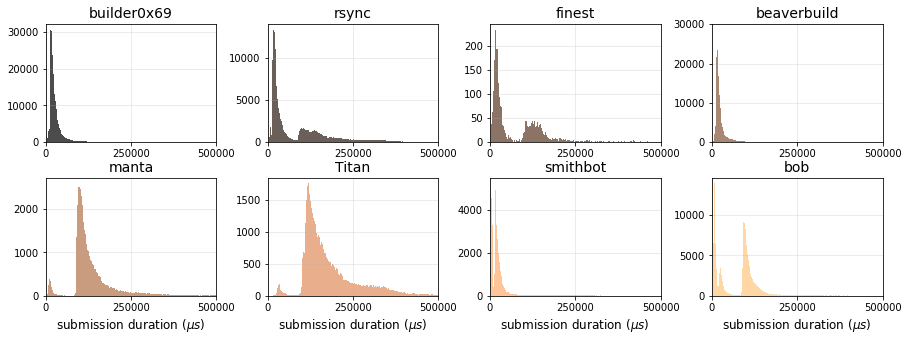

In [126]:
f, axarr = plt.subplots(nrows=2,ncols=4, figsize=(15,5))

for i, b in enumerate(buids):
    print(i % 4, i//4, b)
    r,c = i//4, i%4
    vals = bdo[bdo['builder_id']==b]['total_duration'].values
    print(len(vals))
    axarr[r,c].hist(
        vals,
        bins=bins,
        color=colors[i],
        alpha=0.7,
        density=False,
        label=b
    )
    if r == 1:
        axarr[r,c].set_xlabel('submission duration $(\mu s)$', size=12)
    axarr[r,c].set_xlim(0,float(0.5e6))
    axarr[r,c].set_title(b, size=14)
    axarr[r,c].set_xticks([0, 250000, 500000])
plt.subplots_adjust(hspace=.3)
plt.subplots_adjust(wspace=.3)
plt.show()


In [106]:
def printdf(df):
    print('decode\_duration & ', end='')
    st = ''
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['decode_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('prechecks\_duration & ', end='')
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['prechecks_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('simulation\_duration & ', end='')
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['simulation_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('redis\_update\_duration & ', end='')
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['redis_update_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')
    st = ''
    print('total\_duration & ', end='')
    for i in [50, 75, 90, 99]:
        st += str(int(np.percentile(df['total_duration'], i)))
        st += " & "
    print(st[:-3] + ' \\\\')

In [116]:
printdf(nopts)

decode\_duration & 85020 & 101600 & 146920 & 304896 \\
prechecks\_duration & 1698 & 2207 & 7363 & 316881 \\
simulation\_duration & 113377 & 148299 & 218973 & 744570 \\
redis\_update\_duration & 6206 & 8859 & 31508 & 567347 \\
total\_duration & 204528 & 285357 & 464722 & 1486526 \\


In [117]:
printdf(opts_builders)

decode\_duration & 16566 & 91327 & 134511 & 326649 \\
prechecks\_duration & 1717 & 2317 & 4940 & 479328 \\
simulation\_duration & 8 & 10 & 12 & 28 \\
redis\_update\_duration & 6911 & 10756 & 25583 & 443122 \\
total\_duration & 30597 & 109495 & 191159 & 1153253 \\


In [131]:
winners = pd.read_csv('big/winningsubs.txt', delimiter="|")
winners['received_at'] = pd.to_datetime(nopts['received_at'], format="%Y-%m-%d%H:%M:%S.%f")
winners['slot_boundary'] = np.asarray([pd.Timestamp(x).round(freq='12S') for x in winners['received_at'].values])
winners['diff'] = [v.total_seconds() for v in winners['slot_boundary'] - winners['received_at']]

winners.head()

,substring,received_at,optimistic_submission,decode_duration,prechecks_duration,simulation_duration,redis_update_duration,total_duration,slot,block_hash,slot_boundary,diff
0,0x8bc8d1,2023-03-13 17:57:45.774553,f,9581,1291,89316,5942,106133,5992187,0xf19358e829a0bd231a45e47fdf66a64573c75bb849c7...,2023-03-13 17:57:48,2.225447
1,0xb5d883,2023-03-13 17:57:45.698805,f,7618,1631,69939,5873,85062,5992228,0x9f7b42578928ea022cad8cfee2d5814182a456704470...,2023-03-13 17:57:48,2.301195
2,0x81babe,2023-03-13 17:57:45.810121,f,90865,3028,100385,6604,200883,5992188,0x9d4008e6922000d26a4c690de8a4ad989b916f408110...,2023-03-13 17:57:48,2.189879
3,0xb5d883,2023-03-13 17:57:43.602490,f,12264,1423,88255,19044,120988,5992190,0x6339f22bd451ed670644cfeff5502d9a8052520a2865...,2023-03-13 17:57:48,4.397510
4,0xb5d883,2023-03-13 17:57:43.675843,f,10573,2102,131210,8006,151892,5992191,0xf950dc49936dc56d9755a9f324389ec776bb2d303f19...,2023-03-13 17:57:48,4.324157


In [134]:
wo = winners[winners['optimistic_submission']=='t']
wn = winners[winners['optimistic_submission']=='f']

In [135]:
len(wo), len(wn)

(1029, 6875)

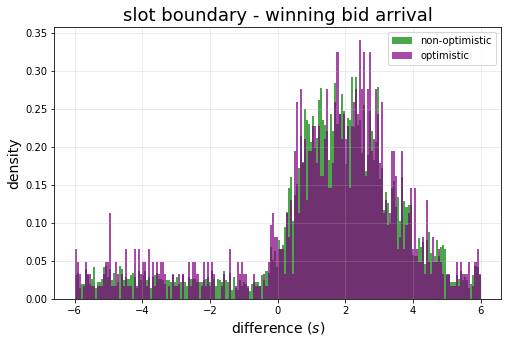

In [151]:
f, ax = plt.subplots(figsize=(8,5))

bins = np.histogram(wn['diff'], bins=200)[1]
ax.hist(wn['diff'], bins, color='g', alpha=0.7, density=True, label='non-optimistic')
ax.hist(wo['diff'], bins, color='purple', alpha=0.7, density=True, label='optimistic')
# ax.set_xlim(0,float(1e6))
ax.set_xlabel('difference $(s)$', size=14)
ax.set_ylabel('density', size=14)
ax.set_title('slot boundary - winning bid arrival', size=18)
plt.legend()
plt.show()